# DIGITAL SIGNAL PROCESSING 1: DATA PREPROCESSING
Dr. Simon Ruch
 
simon.ruch@uni-tuebingen.de

# PREPROCESSING: set environment
set python environment

In [ ]:
do_installs = True
if do_installs:
    !pip install acoustics
    !pip install numpy
    !pip install scipy
    !pip install matplotlib
    !pip install mne
    !pip install pandas
    !pip install tensorpac
    !pip install requests


In [2]:
import acoustics      #=> for creating artificial signals
import numpy as np    #=> for numeric operations
import scipy as sc    #=> for scientific computing
import matplotlib.pyplot as plt #=> for plotting
import mne            #=> for signal processing (M/EEG)

import copy           #=> deepcopying

import pandas as pd   #=> for working with data frames

%matplotlib inline    
                      #=> set plotting backend for notebooks

# PREPROCESSING: basic principles

## Preprocessing: WHY?
Raw electroencephalography data (recordings from depth electrodes: macro- and microelectrodes) contain artifacts that must be removed before the signal can be used for further analyses.
 

Potential artifacts:
* Electromagnetic noise
* Line noise
* Movement artifacts
* Signal jumps
* Potential drifts
* ...

## Preprocessing: HOW?
* Identify artifacts:
    * by visual inspection of raw data
    * by means of simple descriptive statistics (e.g. standard deviation of signal, ...)
* Remove artifacs:
  * Filtering
  * Re-referencing
  * Rejecting 
  * ...

## Artifact identification

### Visual inspection
* Look at the raw data
* Look at the power spectral density (PSD)

Create artificial signal:
* pink-noise data to mimick backround neuronal activity
* 10 s of data
* 1000 Hz sampling rate

In [3]:
#%% Create artificial signal
ieeg = {}
ieeg['dur']   = 10
ieeg['srate'] = 1000
ieeg['time']  = np.arange(0,ieeg['dur']*ieeg['srate'])/ieeg['srate']

ieeg['data'] = acoustics.generator.noise(
    N=ieeg['dur']*ieeg['srate'],
    color='pink',  # pink noise: 1/f distribution
    state=np.random.RandomState(seed=2022) # seed for random numbers generator
    )



#### Inspection of raw signal
Plot artificial signal:

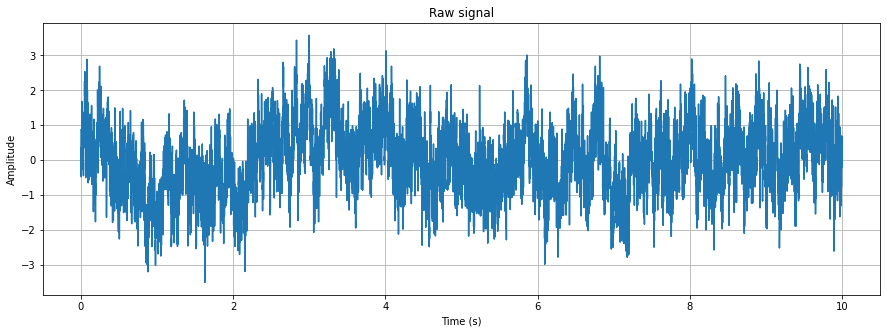

In [4]:
#%% Plot artificial signal
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ieeg['time'],ieeg['data'])

ax.set_title('Raw signal')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.grid()

#### Inspection of power spectral density (PSD)
* A time-series can be described as a sum of oscillations of different frequencies that all have different amplitudes
* Inspecting the different frequency contents (the amplitudes oscillations at different frequencies have) can provide information about potential artifacts in the signal

Compute and plot the PSD of our signal:

    Using multitaper spectrum estimation with 7 DPSS windows


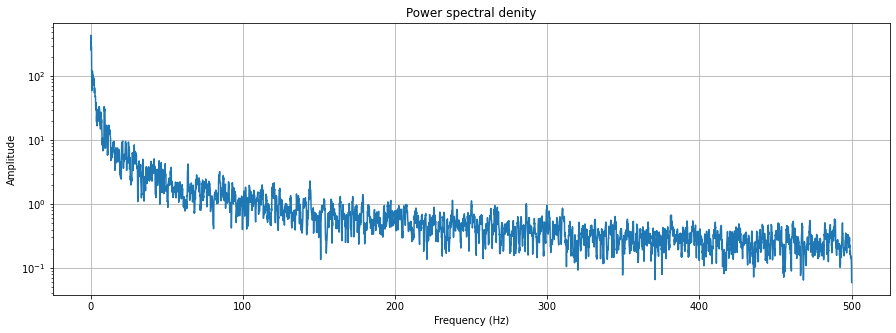

In [5]:
#%% Compute power spectral density (PSD) of signal
ieeg_psd_analytic,ieeg_psd_freqs = mne.time_frequency.psd_array_multitaper(
    x = ieeg['data'],
    sfreq = ieeg['srate'])

#%% Plot PSD of signal
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ieeg_psd_freqs,ieeg_psd_analytic)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_yscale("log")
ax.set_title('Power spectral denity')
ax.grid()

#### Explore data with different spectral properties

Function to create and plot different types of signals:

In [6]:
def create_and_plot_artificial_signal(dur=10,srate = 1000, kind='pink'):
    """
    

    Parameters
    ----------
    dur : float, optional
        Duration of signal in seconds. The default is 10.
    srate : float, optional
        sampling-rate of signal. The default is 1000.
    kind : string({white, pink, blue, brown, violet}), optional
        Type of random noise that is generated. The default is 'pink'.

    Returns
    -------
    noise data: dict with fields
    data : np array containing the actual data
    srate : sampling rate 
    time : np array containing the time-stamps (in s) for each sample

    """
    # => some pink noise
    noise_dat = {}

    noise_dat['data'] = acoustics.generator.noise(
        N=dur*srate,        # 10`000 samples
        color=kind,  # white noise: all frequencyies are equally present
        state=np.random.RandomState(seed=2022) # seed for random numbers generator
        )

    noise_dat['srate'] = srate
    noise_dat['time'] = np.arange(0,len(noise_dat['data']))/noise_dat['srate']
    
    

    # Compute psd    
    noise_dat_psd_analytic,noise_dat_psd_freqs = mne.time_frequency.psd_array_multitaper(
        x = noise_dat['data'],
        sfreq = noise_dat['srate'])
        
    # Plot raw signal and PSD
    fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize = (15,5))
    
    ax[0].plot(noise_dat['time'],noise_dat['data'])
    ax[0].set_title('Raw signal')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    ax[0].grid()
    
    
    ax[1].plot(noise_dat_psd_freqs,noise_dat_psd_analytic)
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Amplitude')
    ax[1].set_yscale("log")
    ax[1].set_title('Power spectral denity')
    ax[1].grid()
    fig.tight_layout()
    
    return noise_dat   

Explore different types of signals:
* white
* pink
* blue
* brown
* violet

    Using multitaper spectrum estimation with 7 DPSS windows


{'data': array([ 0.87506392,  0.75011825,  0.33414657, ...,  0.69512362,
         0.53868857, -0.20970507]),
 'srate': 1000,
 'time': array([0.000e+00, 1.000e-03, 2.000e-03, ..., 9.997e+00, 9.998e+00,
        9.999e+00])}

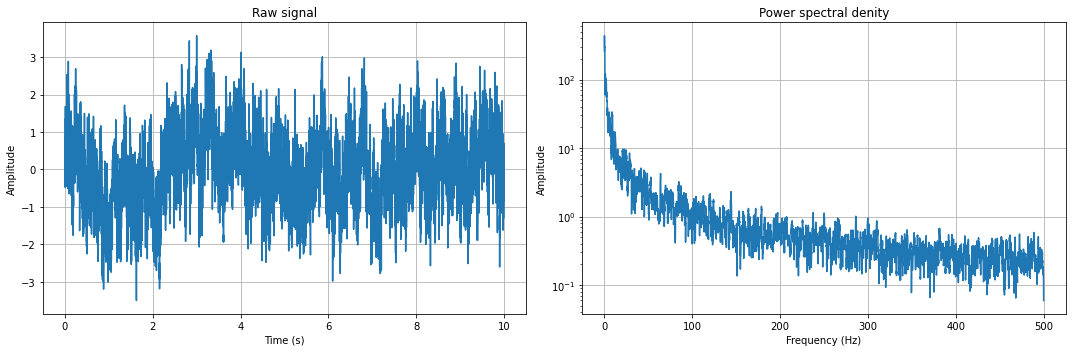

In [8]:
create_and_plot_artificial_signal(dur=10,srate = 1000, kind='pink')

ASSIGNMENT: Explore which type of signal looks like actual electrophysiological data from within the brain

    Using multitaper spectrum estimation with 7 DPSS windows


{'data': array([ 1.31231048,  0.40912962,  0.40691704, ...,  0.83275992,
         0.65039479, -1.71325239]),
 'srate': 1000,
 'time': array([0.000e+00, 1.000e-03, 2.000e-03, ..., 9.997e+00, 9.998e+00,
        9.999e+00])}

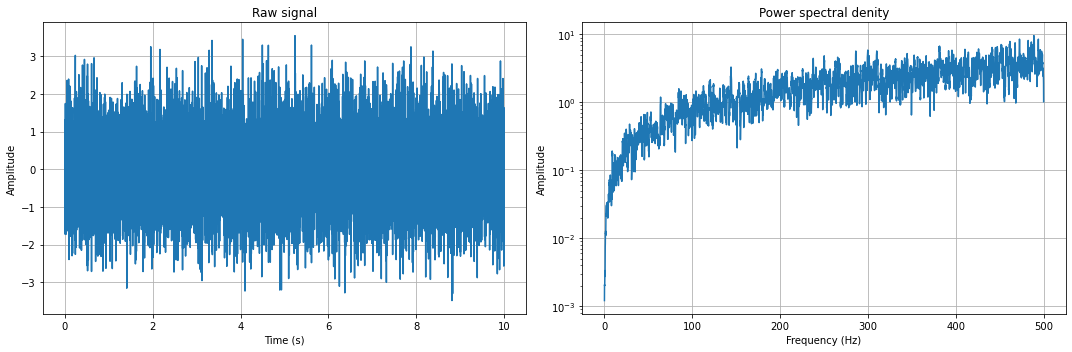

In [11]:
# ASSIGNMENT:
create_and_plot_artificial_signal(dur=10,srate = 1000, kind='blue')
# => hint: use the above code, but plot different kinds of signal (white noise, ...)

#### EXCURSUS: time-domain vs. frequency domain
* Raw data are represented in the time-domain (voltage fluctuations across time)
* These fluctuations can be represented in the frequency domain: sum of oscillations (sine/cosine waves) that all have different ...
  * ... frequencies
  * ... amplitudes ("power")
  * ... phases

Function for creating a sum of oscillations:

In [12]:
# Function for creating and plotting 
def sum_of_cosine_waves(duration, fsample, cosine_wave_params, do_plot = True):
    """
    Create signal by combining cosine-waves with different frequencies, 
    amplitudes, and phase-offsets, plot the signal

    Parameters
    ----------
    duration : float
        duration of artificial signal in seconds
    fsample : TYPE
        sampling rate of artificial signal
    cosine_wave_params : list of dicts
        list of dicts with amplitude, frequency, and phase-shift of signal.
        Fields:
            - amp: float
            - freq: float, in Hz 
            - phase: float, -PI to PI
    doplot: bool (default: True)
        whether or not to plot the data
        

    Returns
    -------
    data: dict
        Dictionnary containing the artificial signal. Keys:
            'time': time vector
            'data': the time series
            'srate': sampling rate
    fig: figure handle, [] if do_plot = False
    """
    dat = {}
    
    dat['srate'] = fsample
    dat['time'] = np.arange(0,duration*fsample)/fsample
    dat['type'] = ['eeg']
    dat['data'] = [np.zeros(dat['time'].shape)]
    
    
    for Wi in cosine_wave_params:
        dat['data'][0] = dat['data'][0] + \
            Wi['amp']*np.cos(dat['time']*2*np.pi*Wi['freq']+Wi['phase'])
        
    
        
    psd = mne.time_frequency.psd_array_multitaper(
        x = dat['data'][0],
        sfreq = dat['srate'],
        output = 'complex')
    
    dat['psd_pow']     = np.abs(np.mean(psd[0],0))
    dat['psd_phase']   = np.angle(np.mean(psd[0],0))
    dat['psd_freqs']   = psd[1]
    
    fig = []
    
    if do_plot:
        fig, ax = plt.subplots(nrows = 3,figsize = (15,10)) 
        
        ax[0].plot(dat['time'],dat['data'][0])
        ax[0].set_xlabel('Time (s)')
        ax[0].set_ylabel('Amplitude')
        ax[0].set_title('Raw signal')
        ax[0].grid()
        
        
        ax[1].plot(dat['psd_freqs'],dat['psd_pow'])
        ax[1].set_xlabel('Frequency (Hz)')
        ax[1].set_ylabel('Amplitude')
        ax[1].set_yscale('log')
        ax[1].set_title('Power spectral density')
        ax[1].grid()
        
        
        ax[2].plot(dat['psd_freqs'],dat['psd_phase'])
        ax[2].set_xlabel('Frequency (Hz)')
        ax[2].set_ylabel('Phase (Rad)')
        ax[2].set_ylim(-3.2,3.2)
        ax[2].set_title('Phase')
        ax[2].grid()
        
        fig.tight_layout()
            
    
    
    return dat, fig


Create and plot sum of oscillations: 1 Hz plus 20 Hz:

    Using multitaper spectrum estimation with 7 DPSS windows


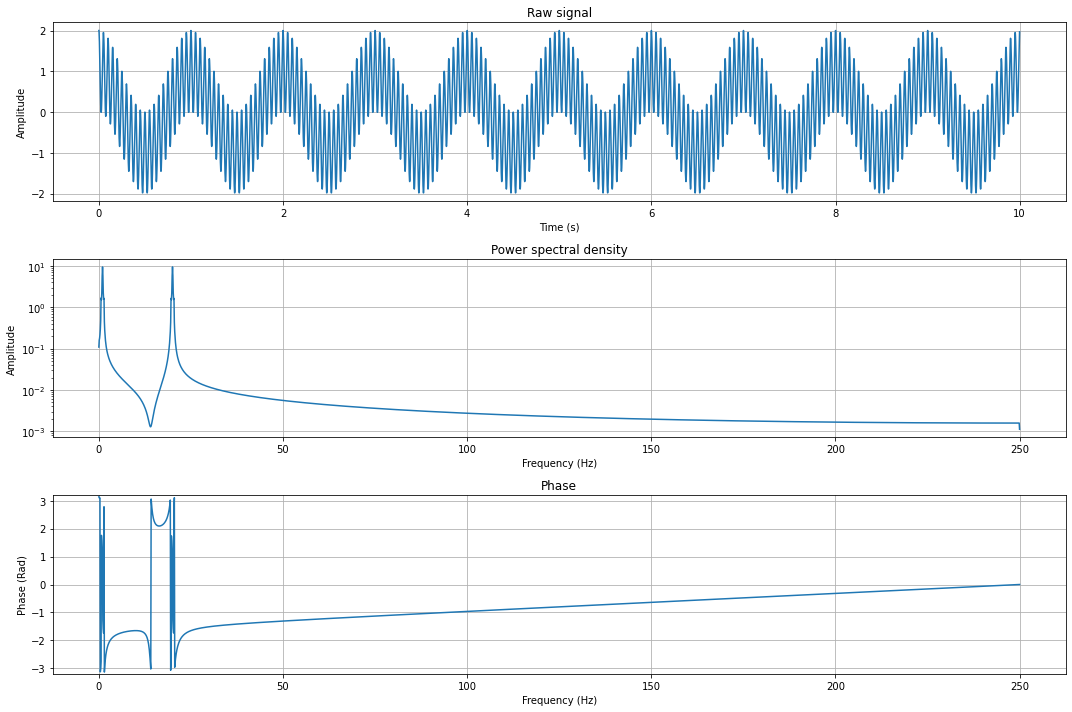

In [13]:
ieeg, fig = sum_of_cosine_waves(10,500,
                        [{'amp':1,'freq':1,'phase':0},
                        {'amp':1,'freq':20,'phase':0}])

ASSIGNMENT: 
* Explore what happens when oscillations with very similar frequencies are combined (e.g. 10 and 11 Hz).
* Explore what happens when oscillations with frequencies that are an integer multiple of the fundamental frequency are combined.
* Explore what happens when oscillations are added that have frequencies close to the sampling frequency.
* Explore what happens to low-frequency oscillations when the data window is very short.
* Explore what happens to high-frequency oscillations when the sampling rate is low.


    Using multitaper spectrum estimation with 7 DPSS windows


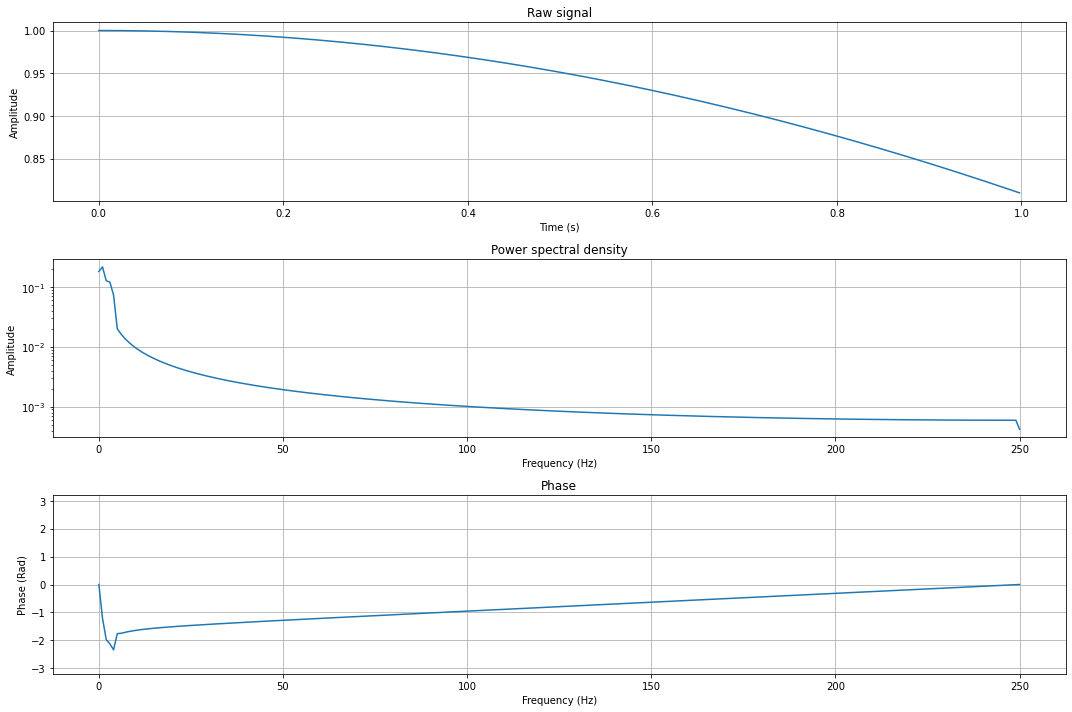

In [24]:
# ASSIGMNENT:
# hint: modify the following code
ieeg, fig = sum_of_cosine_waves(
    duration = 1,
    fsample=500,
    cosine_wave_params = [
        {'amp':1,'freq':0.1,'phase':0},
    ])

### Types of artifacts

Create an artificial signal with different types of artifacts:
* 10 s of data
* 1000 Hz sampling rate
* Pink noise as "true" neuronal background activity
* Waxing and waning 10 Hz oscillation as true brain signal
* Artifacts:
    * stationnary 50 Hz line noise
    * stationnary 20 Hz noise
    * 80 Hz noise burst 
    * signal jump
    * signal drift


In [25]:
# Create signal
ieeg = {}
ieeg['srate'] = 1000
ieeg['dur']  = 10
ieeg['time'] = np.arange(0,ieeg['dur']*ieeg['srate'])/ieeg['srate']

ieeg['data'] = []
ieeg['type'] = []

# True signal: pink noise
ieeg['type'].append('EEG background data')
ieeg['data'].append(acoustics.generator.noise(
    N=len(ieeg['time']),        # 10`000 samples
    color='pink',  
    state=np.random.RandomState(seed=2022) # seed for random numbers generator
    ))

# true signal waxing and waning 10 Hz oscillatoin
ieeg['type'].append('Waxing & waning 10 Hz oscillations')
ieeg['data'].append((0.5+0.5*np.sin(ieeg['time']*0.2*2*np.pi))*np.sin(ieeg['time']*10*2*np.pi))

# add 50 Hz sine-wave
ieeg['type'].append('50 Hz noise')
ieeg['data'].append(np.sin(ieeg['time']*50*2*np.pi))


# add 20 Hz sine-wave
ieeg['type'].append('20 Hz noise')
ieeg['data'].append(np.sin(ieeg['time']*20*2*np.pi))

# add 80 Hz burst
ieeg['type'].append('80 Hz burst')
ieeg['data'].append(
    2*sc.stats.norm.pdf(ieeg['time'],loc=3,scale=.1)*np.sin(ieeg['time']*80*2*np.pi))

# add jump
ieeg['type'].append('signal jump')
ieeg['data'].append(
    np.zeros(ieeg['time'].shape)+5*np.ones(ieeg['time'].shape)*(ieeg['time']>7))


# add slow drift
ieeg['type'].append('signal drift')
ieeg['data'].append(4*np.sin((ieeg['time']+2)*0.05*2*np.pi))

# add sum of all signals
ieeg['type'].insert(0,'Sum of signals')
ieeg['data'].insert(0,np.row_stack(ieeg['data']).sum(axis=0))


In [26]:
# Plotting functions

#%% Plot single signal
def plot_eeg_psd(ieeg,signal=0):
    
    fig, ax = plt.subplots(
        nrows=1,
        ncols=2)
    
    ieeg['psd_freqs']   = []
    ieeg['psd_pow']     = []
    
    
    # Compute PSD for all channels    
    
    tmp_analytic,tmp_freqs = mne.time_frequency.psd_array_multitaper(
        x = ieeg['data'][signal],
        sfreq = ieeg['srate'])
    
    ieeg['psd_freqs'].append(tmp_freqs)
    ieeg['psd_pow'].append(tmp_analytic)
    
    # Plot data
    ax[0].plot(ieeg['time'],ieeg['data'][signal],'r')
    ax[0].set_title(ieeg['type'][signal])
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    ax[0].grid()
    
    ax[1].plot(ieeg['psd_freqs'][0],ieeg['psd_pow'][0],'r')                
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Amplitude')
    ax[1].set_yscale("log")
    ax[1].grid()
    ax[1].set_xlim(0,100)
    ax[1].set_yscale("log")
    return fig

def plot_multichannel_eeg_psd(ieeg):
    
    fig, ax = plt.subplots(
        nrows= len(ieeg['data']),
        ncols=2)
    
    ieeg['psd_freqs']   = []
    ieeg['psd_pow']     = []
    
    
    # Compute PSD for all channels    
    for SGi in range(len(ieeg['data'])):
        tmp_analytic,tmp_freqs = mne.time_frequency.psd_array_multitaper(
            x = ieeg['data'][SGi],
            sfreq = ieeg['srate'])
        
        ieeg['psd_freqs'].append(tmp_freqs)
        ieeg['psd_pow'].append(tmp_analytic)
    
    # Plot data
    for SGi in range(len(ieeg['data'])):
        ax[SGi,0].plot(ieeg['time'],ieeg['data'][0],'r')
        if SGi>0:
            ax[SGi,0].plot(ieeg['time'],ieeg['data'][SGi])
        ax[SGi,0].set_title(ieeg['type'][SGi])
        ax[SGi,0].set_xlabel('Time (s)')
        ax[SGi,0].set_ylabel('Amplitude')
        ax[SGi,0].grid()
        
        ax[SGi,1].plot(ieeg['psd_freqs'][0],ieeg['psd_pow'][0],'r')                
        if SGi>0:
            ax[SGi,1].plot(ieeg['psd_freqs'][SGi],ieeg['psd_pow'][SGi])
        ax[SGi,1].set_xlabel('Frequency (Hz)')
        ax[SGi,1].set_ylabel('Amplitude')
        ax[SGi,1].set_yscale("log")
        ax[SGi,1].grid()
        ax[SGi,1].set_xlim(0,100)
    return fig


Plot final signal with all "true" brain signals and artifacts:
* Red: final artificial signal (sum of all signals)
* Blue: specific signal components that are added to form the red signal

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


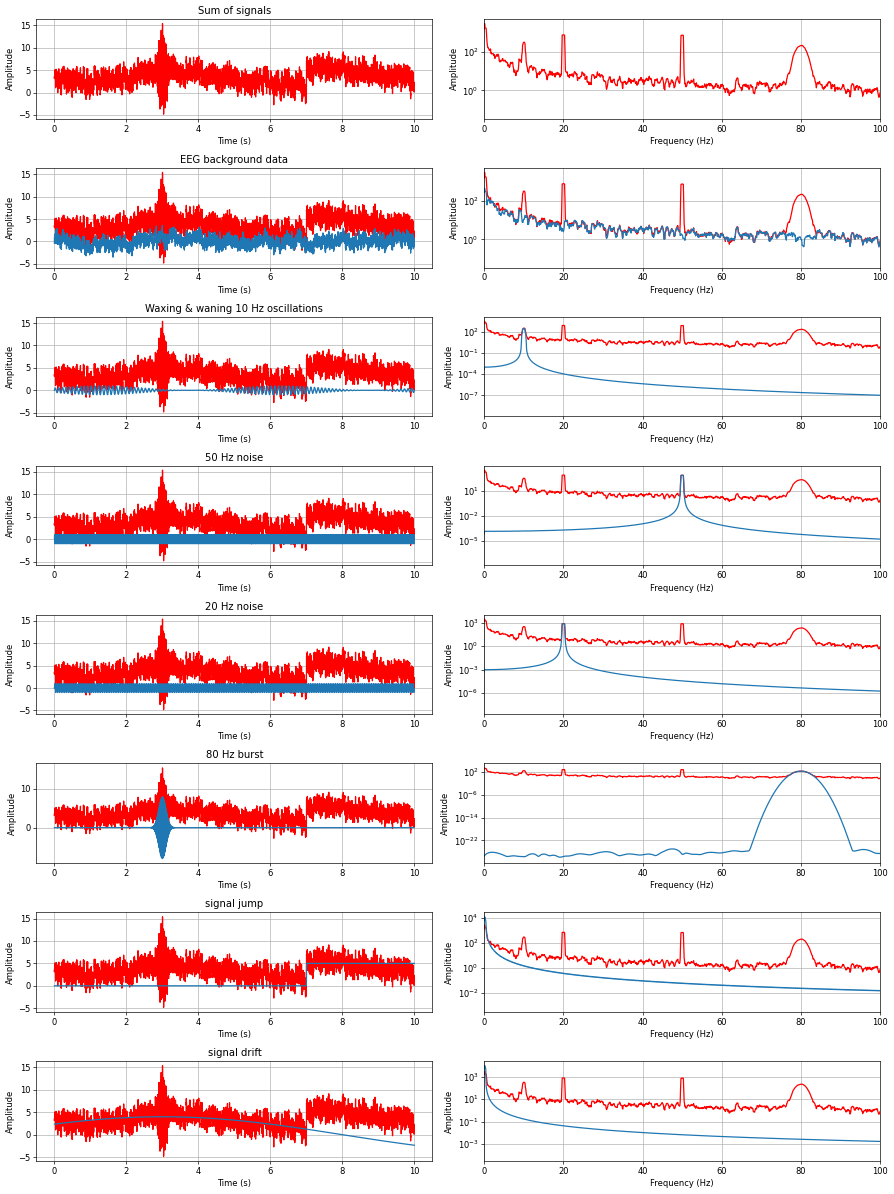

In [27]:
fig = plot_multichannel_eeg_psd(ieeg)
fig.set_size_inches(15,20)
fig.set_dpi(60)
fig.tight_layout()

Explore single signals

    Using multitaper spectrum estimation with 7 DPSS windows


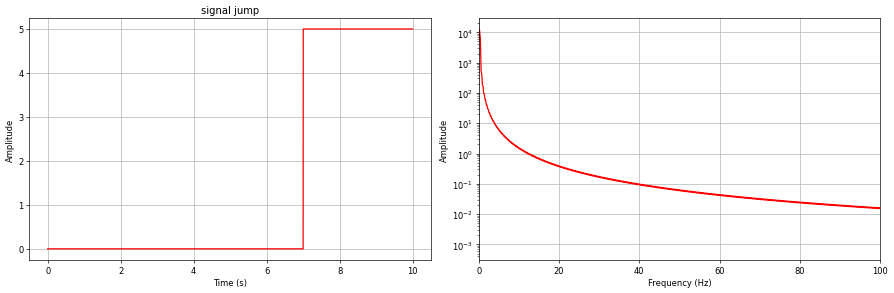

In [31]:
fig = plot_eeg_psd(ieeg,6)
fig.set_size_inches(15,5)
fig.set_dpi(60)
fig.tight_layout()

ASSIGNMENT: plot each artifact separately

In [ ]:
# ASSIGNMENT:
# => hint: use the above function to access the different signal in ieeg

### Artifact removal

#### Filtering
Types of filters:
* High-pass
* Low-pass
* Band-pass
* Notch

Additional information on filtering:
* de Cheveigné, A., & Nelken, I. (2019). Filters: When, Why, and How (Not) to Use Them. Neuron, 102(2), 280–293.
https://doi.org/10.1016/j.neuron.2019.02.039
* Filtering tutorial: https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html



In [32]:
#%% Keep only previously generated signal
ieeg_filt = copy.deepcopy(ieeg)

ieeg_filt['data']= [ieeg_filt['data'][0]]
ieeg_filt['type'] = ['Original']

Apply different types of filters

In [33]:
# Apply different types of filters
ieeg_filt['type'].append('High-pass')
ieeg_filt['data'].append(
    mne.filter.filter_data(ieeg_filt['data'][0],
                           sfreq=ieeg_filt['srate'],
                           l_freq = 10,
                           h_freq = None))

ieeg_filt['type'].append('Low-pass')
ieeg_filt['data'].append(
    mne.filter.filter_data(ieeg_filt['data'][0],
                           sfreq=ieeg['srate'],
                           l_freq = None,
                           h_freq = 25))

ieeg_filt['type'].append('Band-pass')
ieeg_filt['data'].append(
    mne.filter.filter_data(ieeg_filt['data'][0],
                           sfreq=ieeg_filt['srate'],
                           l_freq = 10,
                           h_freq = 25))

ieeg_filt['type'].append('Notch')
ieeg_filt['data'].append(
    mne.filter.notch_filter(ieeg_filt['data'][0],
                            Fs=ieeg_filt['srate'],
                            freqs=[50]))


Setting up high-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Filter length: 1321 samples (1.321 sec)

Setting up low-pass filter at 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 529 samples (0.529 sec)

Setting up band-pass filter from 10 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

Plot the effect of distinct filters:
* Red: original signal
* Blue: signal after filtering


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


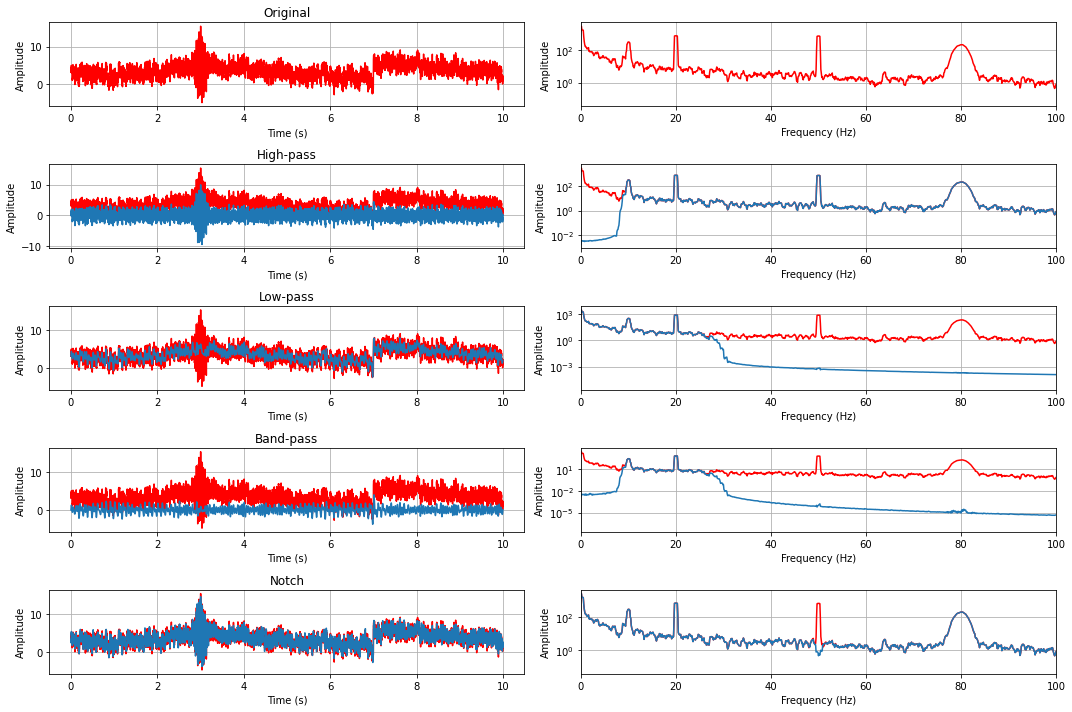

In [34]:
fig = plot_multichannel_eeg_psd(ieeg_filt)
fig.set_size_inches(15,10)
fig.tight_layout()

ASSIGNMENT:
* Combine different filters to clean the signal 
* Plot the result

Setting up band-pass filter from 10 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1321 samples (1.321 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

    Using multitaper spectrum estimation with 7 DPSS windows


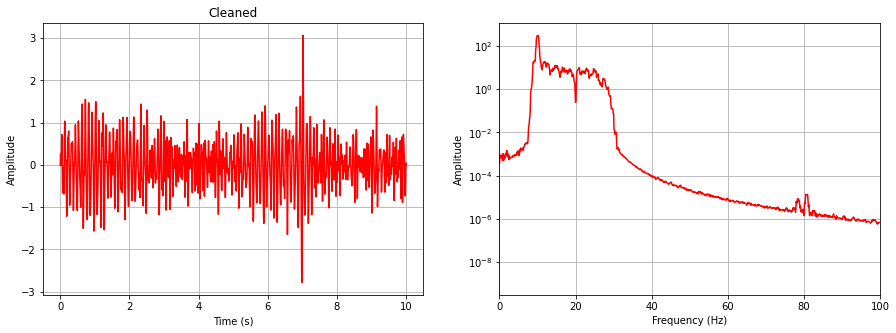

In [36]:
# ASSIGNMENT
# => hint: adjust l_freq, h_freq, and freqs in following code
# Keep only the summed signal with artifacts
ieeg_clean = copy.deepcopy(ieeg)
ieeg_clean['data']= [ieeg_clean['data'][0]]
ieeg_clean['type'] = ['Cleaned']

# Filter the signal
ieeg_clean['data'][0] = mne.filter.filter_data(ieeg_clean['data'][0],
                           sfreq=ieeg_clean['srate'],
                           l_freq = 10,
                           h_freq = 25)


ieeg_clean['data'][0] = mne.filter.notch_filter(ieeg_clean['data'][0],
                            Fs=ieeg_clean['srate'],
                            freqs=[20, 50, 80, 100, 150])


fig = plot_eeg_psd(ieeg_clean,0)
fig.set_size_inches(15,5)

#### Filter artifacts
Filtering can introduce artifacts which may look like biologicas signals. E.g. ringing

Create and plot an artificial signal

In [37]:
# Create a signal with a strong artifact => boxcar
artifact = {}

artifact['srate'] = 1000
artifact['dur']  = 10

artifact['time'] = np.arange(0,artifact['dur']*artifact['srate'])/artifact['srate']

artifact['data'] = [np.zeros(artifact['time'].shape)]
artifact['type'] = ['jump']

artifact_times = [4,6]
    
artifact['data'][0][((artifact['time']>min(artifact_times)) &
              (artifact['time'] < max(artifact_times)))] = artifact['data'][0][((artifact['time']>min(artifact_times)) &
                            (artifact['time'] < max(artifact_times)))]+1


    Using multitaper spectrum estimation with 7 DPSS windows


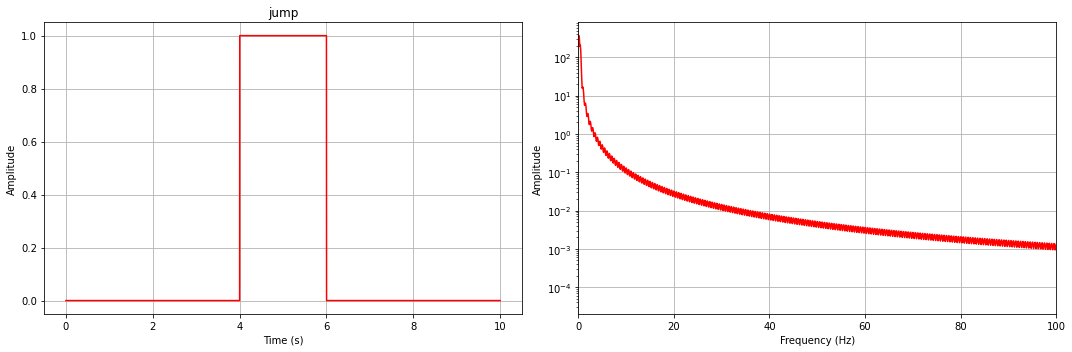

In [38]:
fig = plot_eeg_psd(artifact)
                                                                     
fig.set_size_inches(15,5)
fig.tight_layout()


Filter the signal and plot the result:
* Red: original signal
* Blue: filtered signal

Setting up high-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Filter length: 1321 samples (1.321 sec)

Setting up low-pass filter at 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 529 samples (0.529 sec)

Setting up band-pass filter from 10 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

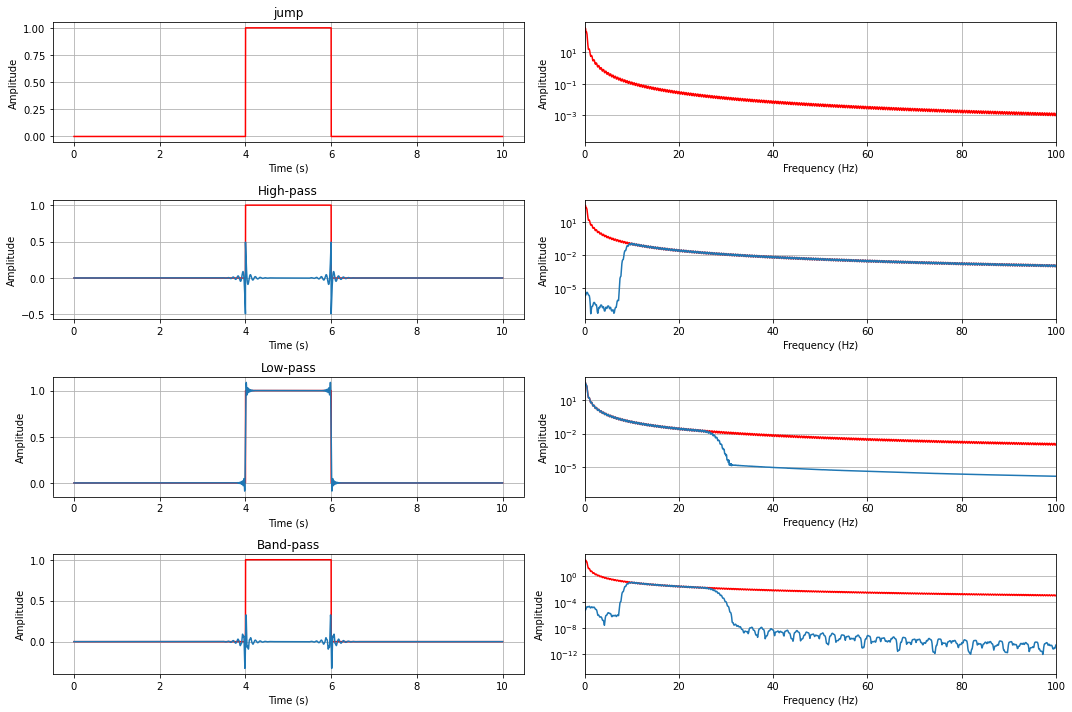

In [39]:
#%% Filter the signal to see/create artifacts
artifact_filt = copy.deepcopy(artifact)

artifact_filt['type'].append('High-pass')
artifact_filt['data'].append(
    mne.filter.filter_data(artifact_filt['data'][0],
                           sfreq=artifact_filt['srate'],
                           l_freq = 10,
                           h_freq = None))

artifact_filt['type'].append('Low-pass')
artifact_filt['data'].append(
    mne.filter.filter_data(artifact_filt['data'][0],
                           sfreq=artifact['srate'],
                           l_freq = None,
                           h_freq = 25))

artifact_filt['type'].append('Band-pass')
artifact_filt['data'].append(
    mne.filter.filter_data(artifact_filt['data'][0],
                           sfreq=artifact_filt['srate'],
                           l_freq = 10,
                           h_freq = 25))




fig = plot_multichannel_eeg_psd(artifact_filt)

fig.set_size_inches(15,10)
fig.tight_layout()


# PREPROCESSING: Practical example

Download intracranial eeg data from Fedele et al., 2017, Scientific Reports.
* Data repository: https://openneuro.org/datasets/ds003498/versions/1.0.1
* Original publication: *Fedele T, Burnos S, Boran E, Krayenbühl N, Hilfiker P, Grunwald T, Sarnthein J. Resection of high frequency oscillations predicts seizure outcome in the individual patient. Scientific Reports. 2017;7(1):13836. https://www.nature.com/articles/s41598-017-13064-1 doi:10.1038/s41598-017-13064-1*

Use MNE to process the data:
* https://mne.tools/stable/index.html

In [40]:
import requests


# Dataset: events
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_events.tsv"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_events.tsv', 'wb').write(r.content)


# Dataset: channel info
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_channels.tsv"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_channels.tsv', 'wb').write(r.content)


# Dataset: header
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_ieeg.vhdr"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_ieeg.vhdr', 'wb').write(r.content)

# Dataset: marker
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_ieeg.vmrk"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_ieeg.vmrk', 'wb').write(r.content)

# Dataset: eeg
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_ieeg.eeg"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_ieeg.eeg', 'wb').write(r.content)



120000000

Import the data using mne:

In [42]:
ieeg = mne.io.read_raw_brainvision('sub-01_ses-interictalsleep_run-01_ieeg.vhdr',preload=True)
ieeg.annotations.crop(0,0)
ieeg.info

Extracting parameters from sub-01_ses-interictalsleep_run-01_ieeg.vhdr...
Setting channel info structure...
Reading 0 ... 599999  =      0.000 ...   300.000 secs...


/tmp/ipykernel_10834/3922152492.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ieeg = mne.io.read_raw_brainvision('sub-01_ses-interictalsleep_run-01_ieeg.vhdr',preload=True)


<Info | 7 non-empty values
 bads: []
 ch_names: IAR1, IAR2, IAR3, IAR4, IAR5, IAR6, IPR1, IPR2, IPR3, IPR4, ...
 chs: 50 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2013-12-07 08:29:20 UTC
 nchan: 50
 projs: []
 sfreq: 2000.0 Hz
>

## Visual inspection

Plot first 10 s of raw data of all channels

In [43]:
# set browser backend to matplotlib => no popup
mne.viz.set_browser_backend('matplotlib')

Using matplotlib as 2D backend.


Opening raw-browser...


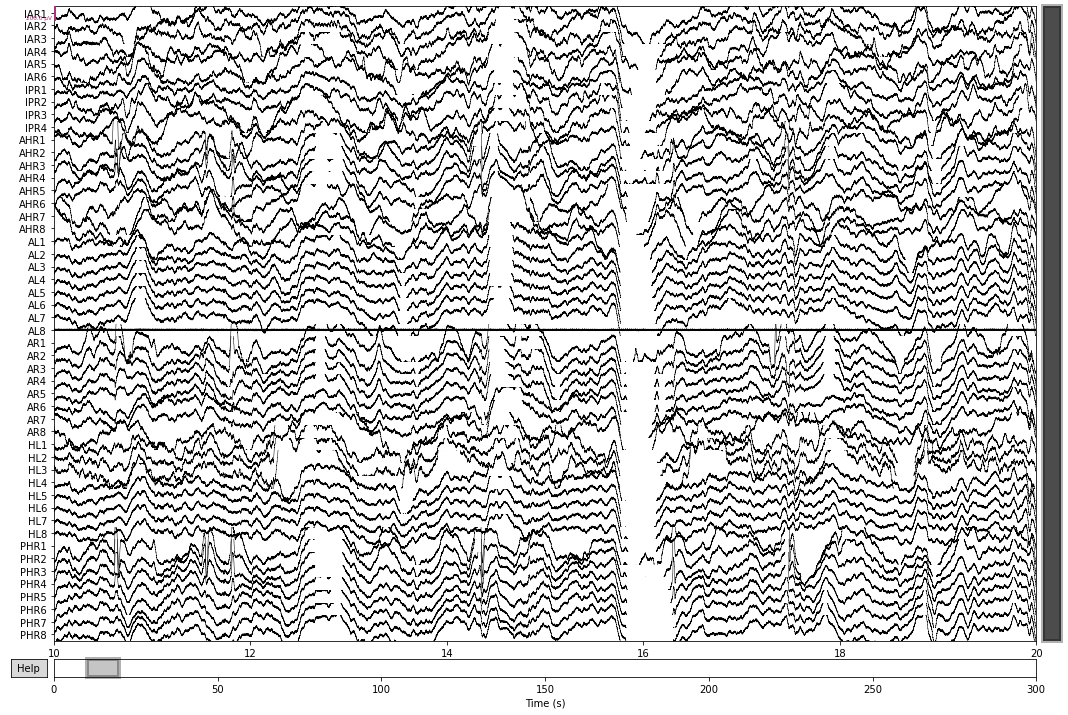

In [45]:
# Plot data
fig = mne.viz.plot_raw(
    ieeg,
    duration=10.0,
    start=10,
    n_channels=50,
    show=False,
    scalings={'eeg':0.0001})

fig.set_size_inches(15,10)

Keep only data from macroelectrode targeting the left amydgala (AL1-8)

In [46]:
ieeg_AL = ieeg.copy().pick_channels(['AL1','AL2','AL3','AL4','AL5','AL6','AL7','AL8'])

Plot raw data from left amydgala

Opening raw-browser...


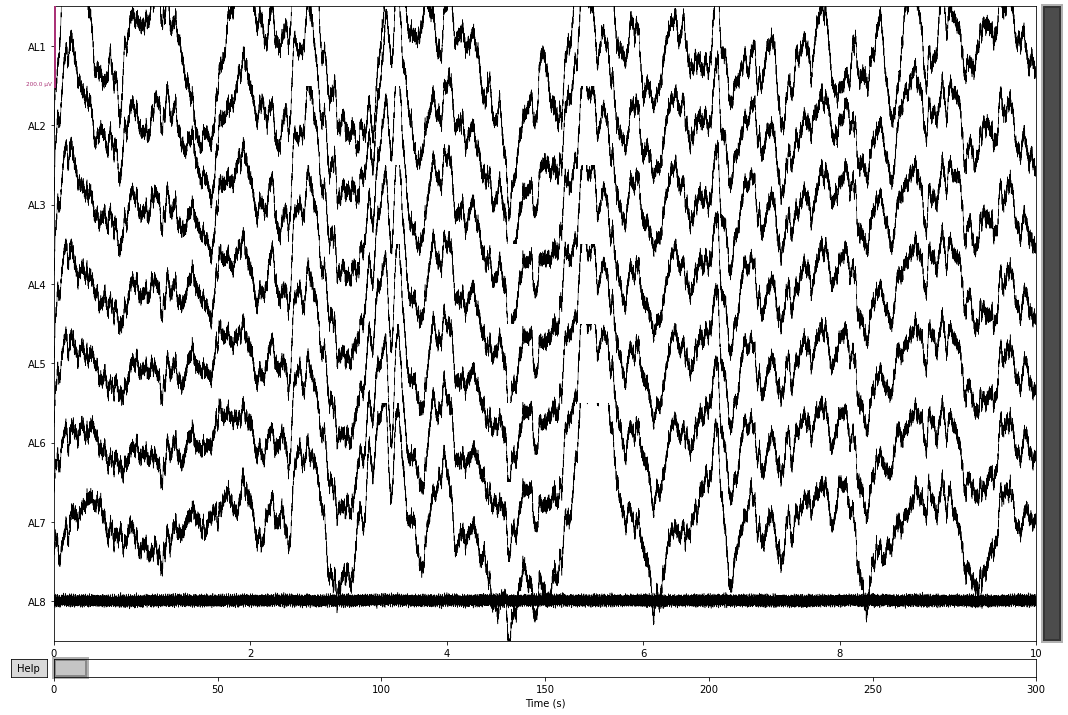

In [47]:
# Plot data
fig = mne.viz.plot_raw(
    ieeg_AL,
    duration=10.0,
    start=0.0,
    n_channels=50,
    show=False,
    scalings={'eeg':0.0001})

fig.set_size_inches(15,10)

ASSIGNMENT: explore other segments of the data

Opening raw-browser...


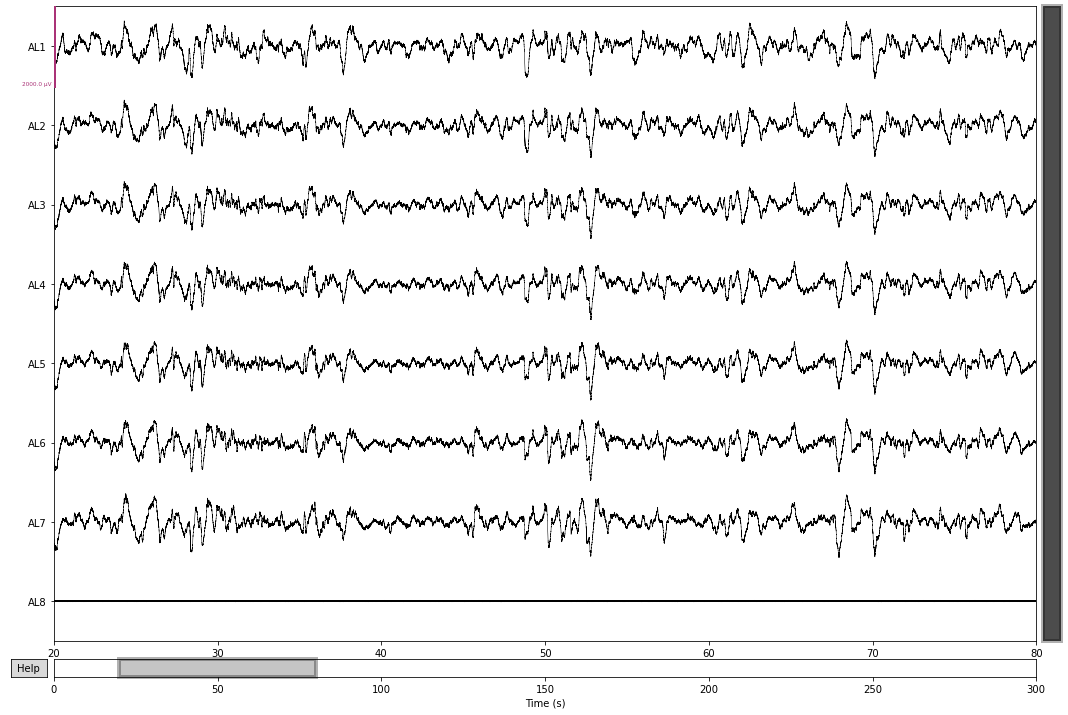

In [51]:
# ASSIGNMENT
# Plot data
fig = mne.viz.plot_raw(
    ieeg_AL,
    duration=60.0,
    start=20,
    n_channels=50,
    show=False,
    scalings={'eeg':0.001})

fig.set_size_inches(15,10)
# => hint: use the above code, but change the start and duration parameters

Plot PSD of raw data:
* Use welch method:
    * Segment data into 2s windows that overlap by 90%
    * Compute PSD for each segment, and average
    
    

Effective window size : 2.000 (s)


/tmp/ipykernel_10834/1402638186.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = ieeg_AL.plot_psd(


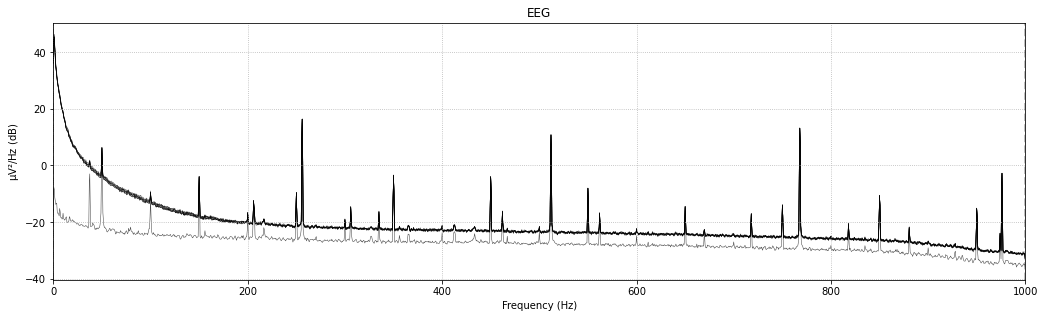

In [52]:
fig = ieeg_AL.plot_psd(
    n_fft = int(2*ieeg_AL.info.get('sfreq')),          # => length of segments: 2* sampling frequency
    n_overlap = int(0.9*2*ieeg_AL.info.get('sfreq')),   # => overlap of segments: 0.9 (90%) of 2s windows
    show=False
)
fig.set_size_inches(15,5)

Visual inspection of the raw data reveals that:
* Channel 8 has no biological signal, is flat => drop
* All other channels are highly correlated, and that all channels have similar noise peaks in the PSD => shared noise component => re-reference data

Drop channel "AL8":

In [53]:
ieeg_AL.drop_channels('AL8')

<RawBrainVision | sub-01_ses-interictalsleep_run-01_ieeg.eeg, 7 x 600000 (300.0 s), ~32.1 MB, data loaded>

Re-reference the EEG to the common average of all channels:
* Compute the mean of all channels at each sample
* Subtract this mean from each single channel at each sampel
* => this removes the shared information from all channels (shared information: most likely noise)

In [57]:
ieeg_AL.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | sub-01_ses-interictalsleep_run-01_ieeg.eeg, 7 x 600000 (300.0 s), ~32.1 MB, data loaded>

Plot re-referenced data from left amydgala

Opening raw-browser...


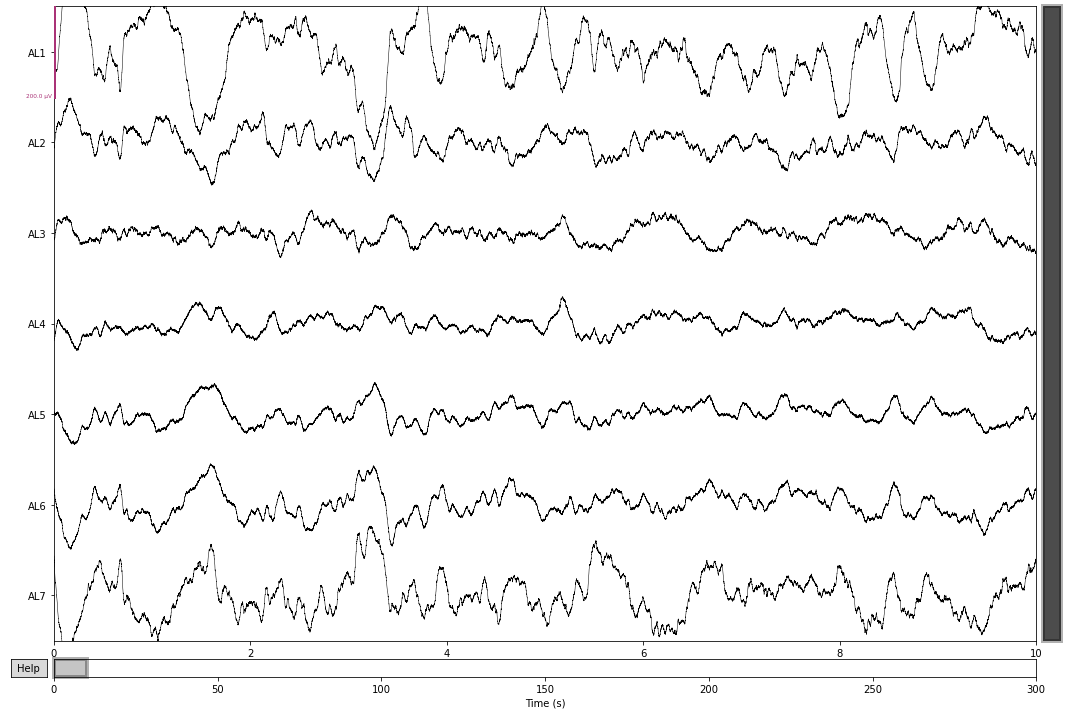

In [58]:
# Plot data
fig = mne.viz.plot_raw(
    ieeg_AL,
    duration=10.0,
    start=0.0,
    n_channels=50,
    show=False,
    scalings={'eeg':0.0001})
fig.set_size_inches(15,10)

Plot PSD for rereferenced data from left amygdala

Effective window size : 2.000 (s)


/tmp/ipykernel_10834/1402638186.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = ieeg_AL.plot_psd(


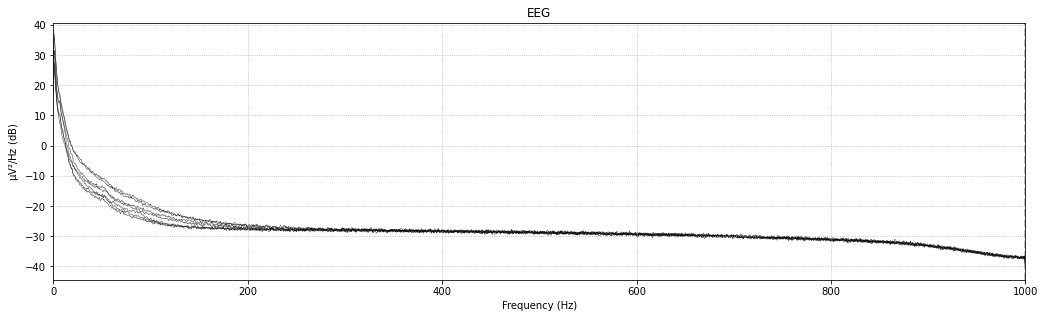

In [59]:
fig = ieeg_AL.plot_psd(
    n_fft = int(2*ieeg_AL.info.get('sfreq')),          # => length of segments: 2* sampling frequency
    n_overlap = int(0.9*2*ieeg_AL.info.get('sfreq')),   # => overlap of segments: 0.9 (90%) of 2s windows
    show=False
)
fig.set_size_inches(15,5)

Focus PSD on frequncies < 200 Hz

Effective window size : 2.000 (s)


/tmp/ipykernel_10834/3841923476.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = ieeg_AL.plot_psd(


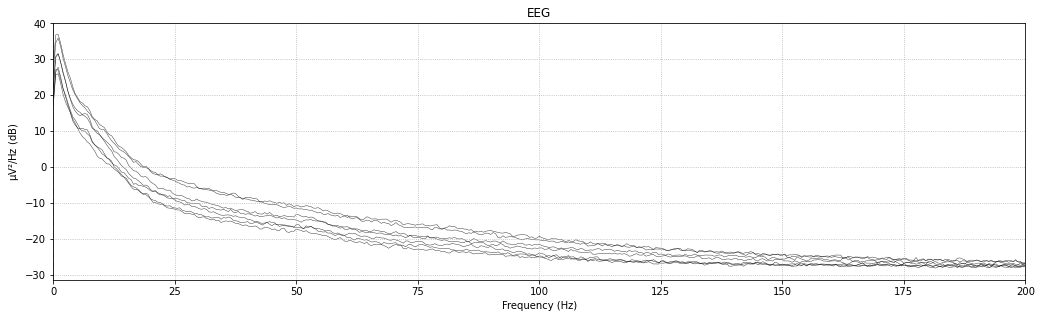

In [60]:
fig = ieeg_AL.plot_psd(
    n_fft = int(2*ieeg_AL.info.get('sfreq')),          # => length of segments: 2* sampling frequency
    n_overlap = int(0.9*2*ieeg_AL.info.get('sfreq')),  # => overlap of segments: 0.9 (90%) of 2s windows
    fmax = 200,                                         # => show data < 200 Hz
    show = False
)
fig.set_size_inches(15,5)

Visual inspection of re-referenced data reveals: 
* Most artifacts that were visible in the PSD are gone
* All channels show similar spectral compositions

## Channel statistics

Compute and report simple descriptive statistics for all channels:
* Mean of signal in time (should be == 0)
* Standard deviation of signal in time (should be similar across channels)
* Maximum absolute amplitude in each channel (should be similar across channel)
* Same statistics for 1st derivative ("diff") of signal (the change in amplituds between sample)
    * ...
* Normalize values by standard deviation to highlight outlier-channel


Observation:
* all channels have similar statistics (all statistics within +/- 2 stds) => no clear outlier

In [62]:
# Compute statistics for each channel, make data frame
channel_stats = pd.DataFrame({
    'channel': ieeg_AL.ch_names,
    'signal_mean':np.mean(ieeg_AL.get_data(),axis=1),
    'signal_std': np.std(ieeg_AL.get_data(),axis=1),
    'signal_max': np.max(np.abs(ieeg_AL.get_data()),axis=1),
    'signaldiff_mean': np.mean(np.diff(ieeg_AL.get_data(),axis=1),axis=1),
    'signaldiff_std': np.std(np.diff(ieeg_AL.get_data(),axis=1),axis=1),
    'signaldiff_max': np.max(np.abs(np.diff(ieeg_AL.get_data(),axis=1)),axis=1),
})


# Normalize
channel_stats_norm = channel_stats.drop(columns=['channel'])
channel_stats_norm = (channel_stats_norm-channel_stats_norm.mean())/channel_stats_norm.std()

channel_stats_norm['channel'] = channel_stats['channel']

channel_stats_norm.set_index('channel',inplace=True)


channel_stats_norm

,signal_mean,signal_std,signal_max,signaldiff_mean,signaldiff_std,signaldiff_max
channel,,,,,,
AL1,-0.104033,1.624643,1.284254,-1.785492,1.618452,0.339759
AL2,0.530861,-0.078275,-0.120741,-0.679739,-0.390057,-0.658775
AL3,-1.250700,-0.787119,-0.789847,0.573843,-0.926601,-0.766686
AL4,0.689334,-0.964084,-0.757528,1.236604,-0.797623,0.046072
AL5,1.388255,-0.800848,-0.857410,0.624039,-0.300180,-0.687385
AL6,0.064076,-0.070891,-0.282935,0.240750,-0.416475,-0.340000
AL7,-1.317791,1.076574,1.524206,-0.210004,1.212484,2.067015


/home/simon/anaconda3/envs/teaching_env/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<AxesSubplot:xlabel='channel'>, <AxesSubplot:xlabel='channel'>,
       <AxesSubplot:xlabel='channel'>, <AxesSubplot:xlabel='channel'>,
       <AxesSubplot:xlabel='channel'>, <AxesSubplot:xlabel='channel'>],
      dtype=object)

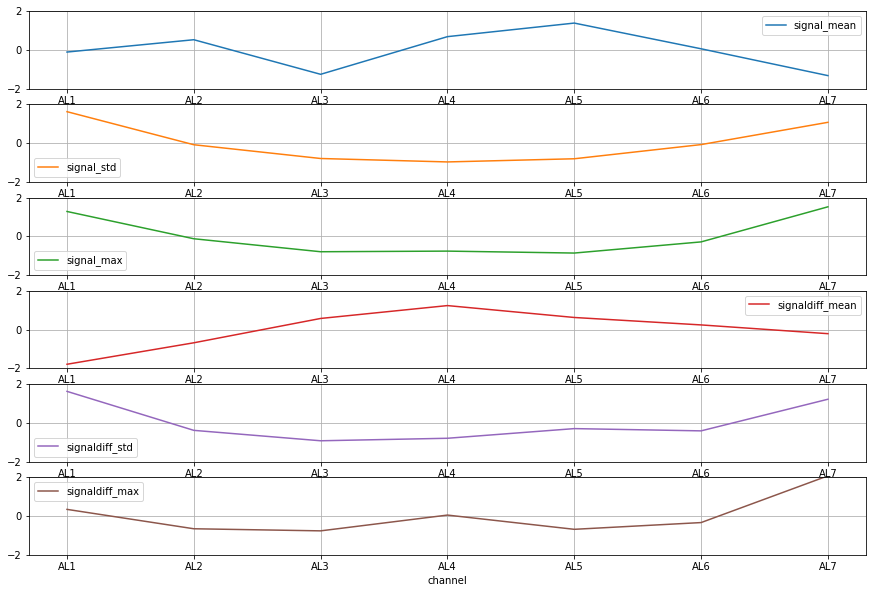

In [63]:
fig, ax = plt.subplots(figsize= (15,10))
channel_stats_norm.plot(subplots = True,
                        ax = ax,
                        grid = True,
                        ylim=[-2, 2])
